# Step 1: Loading the dataset

In [1]:
import pandas as pd

Atl_data = pd.read_csv("traffic_accidents_atlanta.csv")

#dropping rows that contain Atlanta but are not from Georgia, USA
Atl_data.drop(Atl_data[Atl_data['State'] != 'GA'].index, inplace = True)

#dropping the 'Number column' due to dataset author request
Atl_data.drop(columns = ['Number'], inplace = True)

                         
#dropping unnamed column in the dataset that we have no information about
Atl_data = Atl_data.drop("Unnamed: 0", axis = 1)
                         
                         
#target variable for our project
print(Atl_data['Severity'].unique())

print(Atl_data.head())

[2 3 4 1]
          ID  Severity           Start_Time             End_Time  Start_Lat  \
0  A-2749196         2  2016-11-30 17:39:56  2016-11-30 23:39:56  33.741530   
1  A-2749218         2  2016-11-30 18:09:52  2016-12-01 00:09:52  33.912200   
2  A-2749233         2  2016-11-30 18:44:53  2016-12-01 00:44:53  33.927360   
3  A-2749242         2  2016-11-30 18:56:16  2016-12-01 00:56:16  33.741360   
4  A-2749273         2  2016-11-30 20:52:19  2016-12-01 02:52:19  33.759168   

   Start_Lng   End_Lat   End_Lng  Distance(mi)  \
0 -84.414340  33.74658 -84.43034         0.983   
1 -84.383900  33.91138 -84.37258         0.652   
2 -84.357740  33.98695 -84.33940         4.249   
3 -84.414020  33.74119 -84.41173         0.132   
4 -84.378729  33.76159 -84.38080         0.205   

                                         Description  ... Roundabout Station  \
0  Between Ashby St/Exit 55 and Langhorn St/Exit ...  ...      False   False   
1            At US-19/Roswell Rd/Exit 25 - Accident.  

In [2]:
print(Atl_data.describe())

           Severity     Start_Lat     Start_Lng       End_Lat       End_Lng  \
count  11845.000000  11845.000000  11845.000000  11845.000000  11845.000000   
mean       2.489320     33.783714    -84.396131     33.783950    -84.395766   
std        0.718707      0.093175      0.071702      0.093083      0.072505   
min        1.000000     33.569125    -84.654387     33.563020    -84.640150   
25%        2.000000     33.720290    -84.449970     33.725929    -84.450518   
50%        2.000000     33.768097    -84.391997     33.767740    -84.391840   
75%        3.000000     33.880022    -84.357950     33.880790    -84.357960   
max        4.000000     33.999886    -84.238561     34.044400    -84.148484   

       Distance(mi)  Temperature(F)  Wind_Chill(F)   Humidity(%)  \
count  11845.000000    11811.000000    6559.000000  11795.000000   
mean       0.566245       62.528245      57.965467     71.217974   
std        0.677017       15.504473      18.278552     21.155173   
min        0.000

In [3]:
print(Atl_data.isna().sum())

ID                          0
Severity                    0
Start_Time                  0
End_Time                    0
Start_Lat                   0
Start_Lng                   0
End_Lat                     0
End_Lng                     0
Distance(mi)                0
Description                 0
Street                      0
Side                        0
City                        0
County                      0
State                       0
Zipcode                     0
Country                     0
Timezone                    0
Airport_Code                0
Weather_Timestamp          25
Temperature(F)             34
Wind_Chill(F)            5286
Humidity(%)                50
Pressure(in)               26
Visibility(mi)             35
Wind_Direction             47
Wind_Speed(mph)          1137
Precipitation(in)        5116
Weather_Condition          32
Amenity                     0
Bump                        0
Crossing                    0
Give_Way                    0
Junction  

# Step 2: Data preprocessing and exploration

In [4]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler


#handling missing values using mean for numerical columns/features
numeric_features = Atl_data.select_dtypes(include = np.number).columns
impute_mean = SimpleImputer(strategy = 'mean')
Atl_data_numeric = pd.DataFrame(impute_mean.fit_transform(Atl_data[numeric_features]), columns = numeric_features)


#handling missing values using mode for categorical columns/features
categorical_features = Atl_data.select_dtypes(include = 'object').columns
impute_mode = SimpleImputer(strategy = 'most_frequent')
Atl_data_categorical = pd.DataFrame(impute_mode.fit_transform(Atl_data[categorical_features]), columns = categorical_features)


#one-hot encoding for categorical features.... RF classifier expects numeric input, but our dataset still contains categorical features... we need to convert the categorical features into numeric form using one-hot encoding
Atl_data_categorical_encoded = pd.get_dummies(Atl_data_categorical)


#Combining the imputed numeric and (imputed and encoded) categorical data
Atl_data_combined = pd.concat([Atl_data_numeric, Atl_data_categorical_encoded], axis = 1)

In [5]:
#handling outliers using IQR for numeric columns/features
Q1 = Atl_data_combined.quantile(0.25)
Q3 = Atl_data_combined.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#removing the outliers
Atl_data_n = Atl_data_combined[(Atl_data_combined >= lower_bound) & (Atl_data_combined <= upper_bound)]

In [6]:
#Normalizing numeric columns/features (excluding the target variable 'Severity') data using range normalization (MinMaxScaler)
Normalizing_Features = Atl_data_n.drop('Severity', axis = 1).columns
scaler = MinMaxScaler()
normalized_features = pd.DataFrame(scaler.fit_transform(Atl_data_n[Normalizing_Features]), columns = Normalizing_Features)


#combining normalized features with the original 'Severity' column
normalized_Atl_data = pd.concat([Atl_data_n['Severity'], normalized_features], axis = 1)


#Replacing NaN or infinite values with the mean of the column
normalized_Atl_data = normalized_Atl_data.apply(lambda x: x.replace([np.inf, -np.inf], np.nan))
normalized_Atl_data.fillna(normalized_Atl_data.mean(), inplace = True)

In [7]:
#Feature selection using Random Forest
#target feature is 'Severity', it represents the severity of the accident based on 4 classes (1, 2, 3, 4) where 1 is the low severity and 4 is the highest severity
X = normalized_Atl_data.drop('Severity', axis = 1)
y = normalized_Atl_data['Severity']


#intializing the random forest model
rf_model = RandomForestClassifier(random_state = 42)

#train the random forest model
rf_model.fit(X, y)

#get the importance of features
feature_importances = pd.Series(rf_model.feature_importances_, index = X.columns)


#select the most important features
selected_features = feature_importances[feature_importances > 0.01]
columns_selection = selected_features.index

X_selected = X[columns_selection]

# Step 3: Preparing data for machine learning models: 

In [8]:
#train-test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size = 0.3, random_state = 42)

# Step 4: Model Training

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier


#addressing NaN or infinity values in the training data
if X_train.isnull().sum().sum() > 0:
    X_train.fillna(X_train.mean(), inplace = True)

if y_train.isnull().sum() > 0:
    y_train.fillna(y_train.mode()[0], inplace = True)
    

#Intialize the models (gradient boosting classifier, random forest classifier, and logistic regression model)
logistic_reg_model = LogisticRegression(solver = 'lbfgs', max_iter = 1000, random_state = 42)
Gradient_Boo_model = GradientBoostingClassifier(random_state = 42)
Random_For_model = RandomForestClassifier(random_state = 42)


#standardize the data
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train)
X_test_std = scaler_std.transform(X_test)



#addressing Nan or infinity values in the test data
if np.isnan(X_test_std).sum() > 0:
    X_test_std[np.isnan(X_test_std)] = np.nanmean(X_test_std)

X_test_std = np.nan_to_num(X_test_std, nan = 0.0, posinf = None, neginf = None)
    
    
#Training the models
logistic_reg_model.fit(X_train_std, y_train)
Gradient_Boo_model.fit(X_train_std, y_train)
Random_For_model.fit(X_train_std, y_train)

RandomForestClassifier(random_state=42)

# Step 5: Model Evaluation

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


#making prediction using the models
logistic_reg_preds = logistic_reg_model.predict(X_test_std)
Gradient_Boo_preds = Gradient_Boo_model.predict(X_test_std)
Random_For_preds = Random_For_model.predict(X_test_std)


#calculating accuracy for each model
logistic_reg_accuracy = accuracy_score(y_test, logistic_reg_preds)
Gradient_Boo_accuracy = accuracy_score(y_test, Gradient_Boo_preds)
Random_For_accuracy = accuracy_score(y_test, Random_For_preds)

In [11]:
#printing accuracy for each model
print("Logistic Regression Accuracy: ", logistic_reg_accuracy)
print("Gradient Boosting Classifier Accuracy: ", Gradient_Boo_accuracy)
print("Random Forest Classifier Accuracy: ", Random_For_accuracy)

Logistic Regression Accuracy:  0.6074845244794598
Gradient Boosting Classifier Accuracy:  0.6170512099043332
Random Forest Classifier Accuracy:  0.6654473832301632


In [12]:
#printing classification reports
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, logistic_reg_preds, zero_division = 1))
print("\nGradient Boosting Classifier Classification Report:\n", classification_report(y_test, Gradient_Boo_preds, zero_division = 1))
print("\nRandom Forest Classifier Classification Report:\n", classification_report(y_test, Random_For_preds, zero_division = 1))


Logistic Regression Classification Report:
               precision    recall  f1-score   support

         1.0       1.00      0.00      0.00        28
         2.0       0.61      0.99      0.76      2161
         3.0       0.37      0.02      0.03       924
         4.0       1.00      0.00      0.00       441

    accuracy                           0.61      3554
   macro avg       0.74      0.25      0.20      3554
weighted avg       0.60      0.61      0.47      3554


Gradient Boosting Classifier Classification Report:
               precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        28
         2.0       0.63      0.95      0.76      2161
         3.0       0.45      0.12      0.19       924
         4.0       0.73      0.07      0.14       441

    accuracy                           0.62      3554
   macro avg       0.45      0.29      0.27      3554
weighted avg       0.59      0.62      0.53      3554


Random Forest Classifier Class

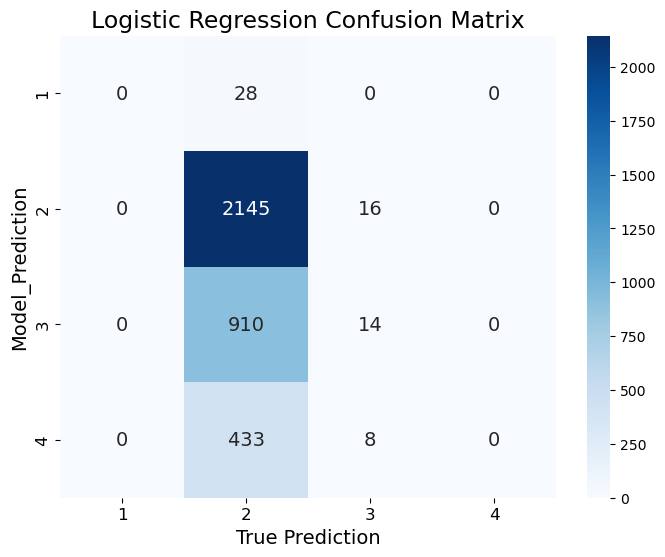

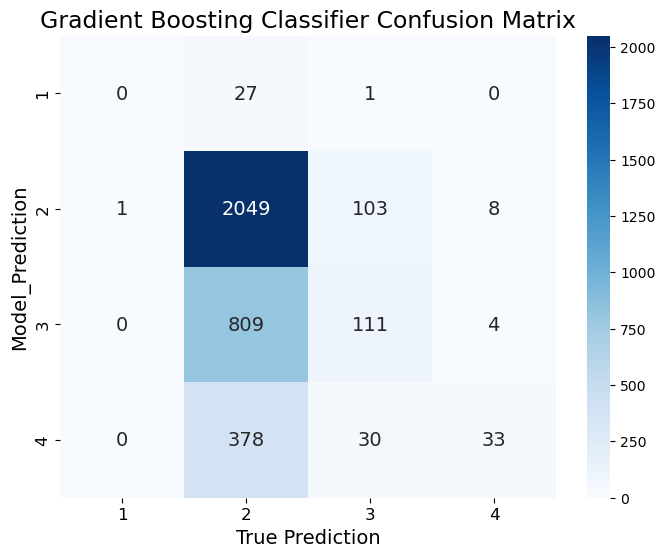

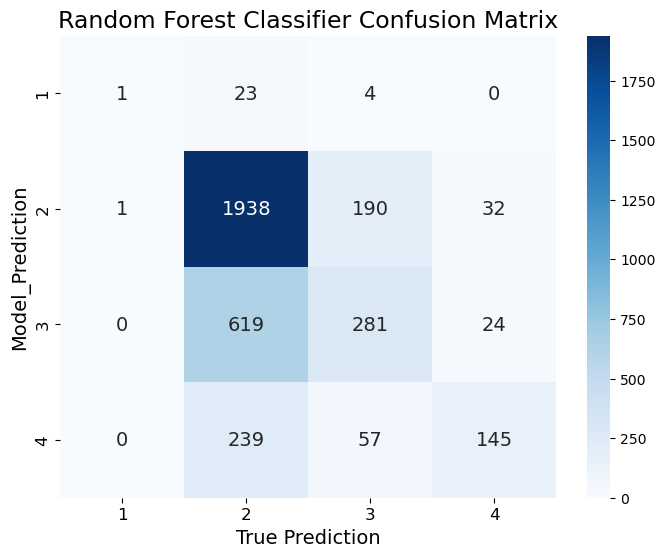

In [13]:
#function for plotting confusion matrices for better visualization
def plot_cm(confusion_m, model):
    plt.figure(figsize = (8, 6))
    sns.heatmap(confusion_m, annot = True, fmt = 'd', cmap = 'Blues', annot_kws = {"size": 14})
    plt.title(f'{model} Confusion Matrix', fontsize = 17)
    plt.xlabel('True Prediction', fontsize = 14)
    plt.ylabel('Model_Prediction', fontsize = 14)
    plt.xticks(ticks = [0.5, 1.5, 2.5, 3.5], labels = ['1', '2', '3', '4'], fontsize = 12)
    plt.yticks(ticks = [0.5, 1.5, 2.5, 3.5], labels = ['1', '2', '3', '4'], fontsize = 12)
    plt.show()



#printing confusion matrices
plot_cm(confusion_matrix(y_test, logistic_reg_preds), 'Logistic Regression')
plot_cm(confusion_matrix(y_test, Gradient_Boo_preds), 'Gradient Boosting Classifier')
plot_cm(confusion_matrix(y_test, Random_For_preds), 'Random Forest Classifier')

# Step 6 Analyzing the results
The Random Forest Model performed the best and heres why...

1. Accuracy Score:
based on the Accuracy Scores from above, we can see that the Random Forest model has the highest accuracy. This means that the Random Forest model has the highest proportion of correct predections out of all instances in the data


2. Classification Report: 
so based on the Precision, Recall, and F1-score for individual classes... Random Forest model has the highest Precision for classes 1, 3, and 4. Random Forest model has the highest recall for classes 1, 3, and 4. Random Forest has the highest F1-score for classes 1, 3, and 4.... for class 2, Gradient Boosting model has a higher F1-score and precision than Random Forest, but not by much.

The Random Forest model also has a the highest weighted average F1-score. This means that the model has the best balance between precision and recall, when taking into account of the class sizes



3. Confusion Matrix: 
Logistic Regression Model- This model is very biased towards class 2 because it has a high number of true positives (2072), but does poorly when correctly predicting the other classes (1, 3, 4). 

Also, it has a large number of false positives for class 2, which means that the model tends to incorrectly predict instances as class 2.


Gradient Boosting Model - Similarily just like the Logistic Regression Model, this model is also has a bias towards class 2, but it does perfom better than Logistic Regression for classes 3 and 4. However, it still has a slightly high number of false positives for class 2.



Random Forest Model - This model also seems to have some bias towards class 2 aswell, but it performs better when correctly predicting for the other classes (1, 3, and 4) compared to the Logistic Regression Model and the Gradient Boosting models. This model is illustrates a more balanced performance across all classes when considereding true positives (correctly predicting the class). When comparing all three models, the Random Forest Model seems to be the least biased and has the better performance across all classes.

# Step 7: Feature Importance

In [14]:
#using the top most important features from the model that performed the best for us (Random Forest)
#doing this so that we can identify the most influential factors contributing to the severity of traffic accidents

rf_important_features = feature_importances.sort_values(ascending = False)
print("Top 10 important features from the Random Forest model:")
for index, feature in enumerate(rf_important_features[:10].index):
    print(f"{index + 1}. {feature}: {rf_important_features[feature]}")

Top 10 important features from the Random Forest model:
1. Pressure(in): 0.1276612773002769
2. Temperature(F): 0.10724640760119163
3. Humidity(%): 0.10178054235745407
4. Distance(mi): 0.09157324622378477
5. End_Lng: 0.09156435108700021
6. End_Lat: 0.09108687187131835
7. Start_Lng: 0.09063820899278098
8. Start_Lat: 0.08909740754425156
9. Wind_Speed(mph): 0.08160716019516516
10. Wind_Chill(F): 0.043746864199890316


# Step 8: visualization of results based on top 10 important features from the Random Forest model

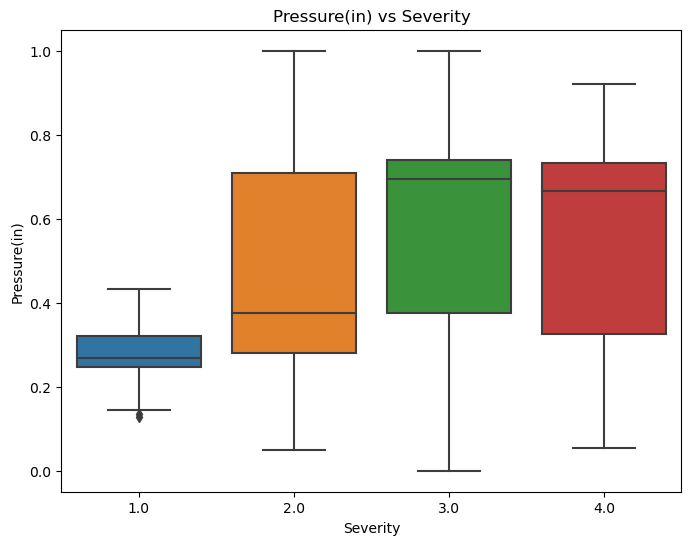

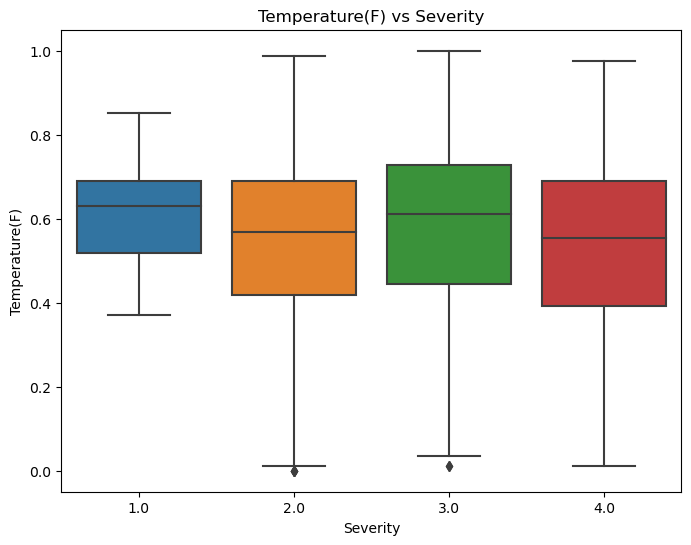

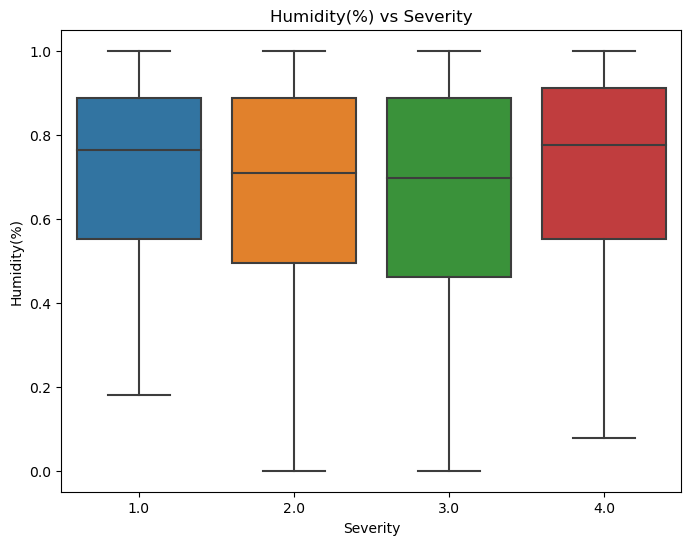

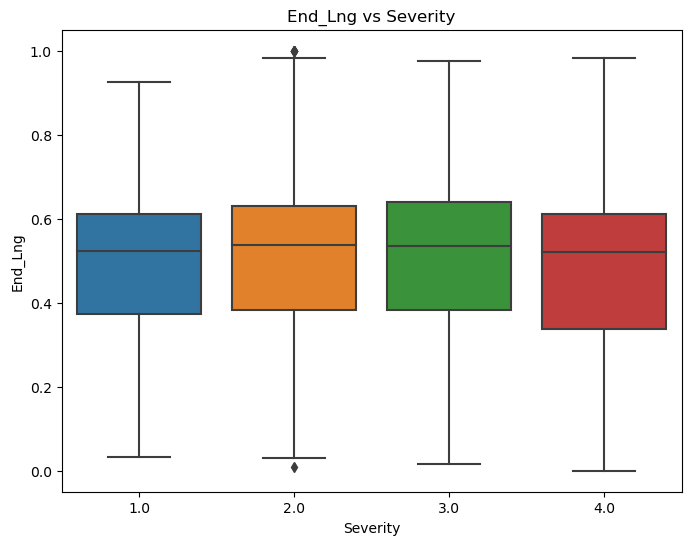

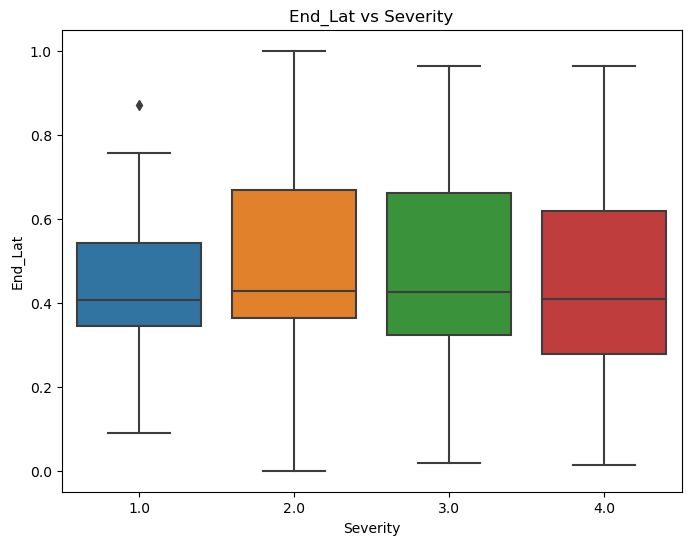

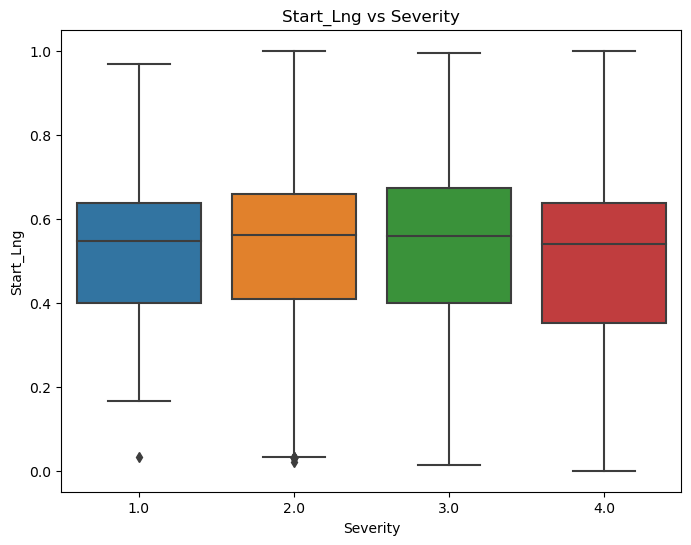

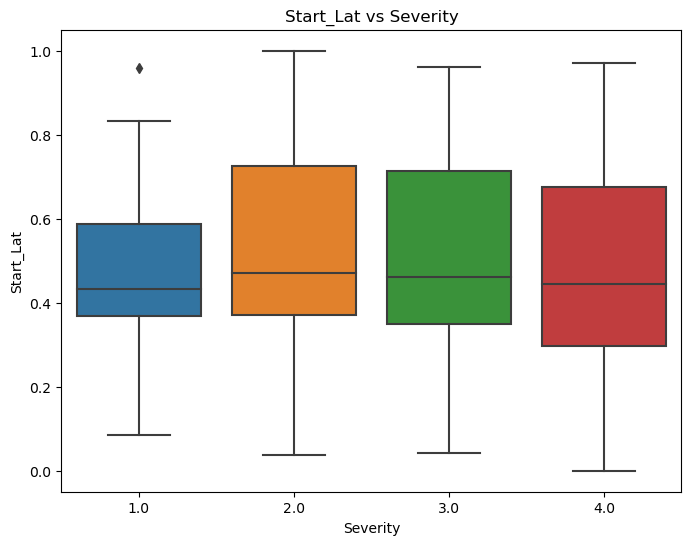

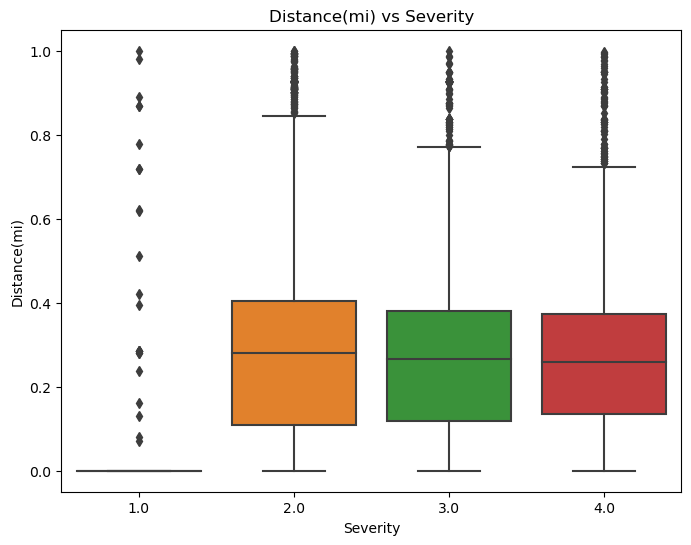

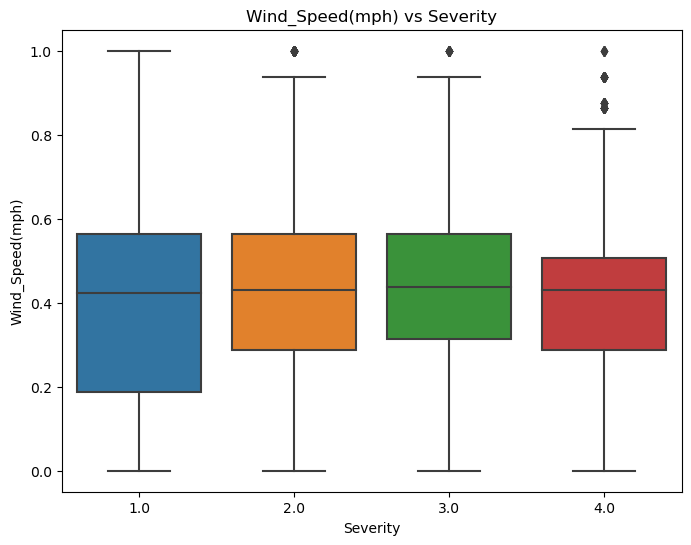

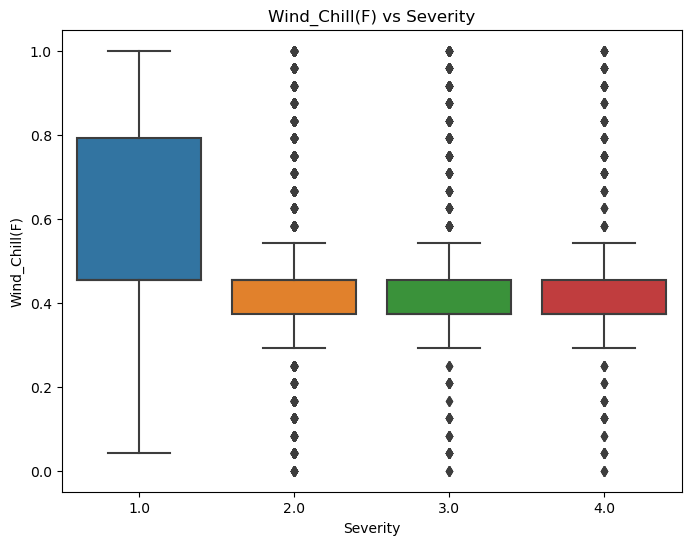

In [15]:
#dataframe containing the top 10 important features form the Random Forest model
top_ten_featuresDF = normalized_Atl_data[['Pressure(in)', 'Temperature(F)', 'Humidity(%)', 'End_Lng', 'End_Lat', 'Start_Lng', 'Start_Lat', 'Distance(mi)', 'Wind_Speed(mph)', 'Wind_Chill(F)', 'Severity']]

#boxplots for each feature against the target variable ('Severity') 
for feature in top_ten_featuresDF.columns[:-1]:
    plt.figure(figsize= (8, 6))
    sns.boxplot(x = 'Severity', y = feature, data = top_ten_featuresDF)
    plt.title(f'{feature} vs Severity')
    plt.show()